# Does alcohol Consumption Make our Sleep Less Efficient?

In [473]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core.frame import DataFrame
from IPython.display import display
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

 ### 1. ensure data types are appropriate and there is no missing data

In [474]:
df = pd.read_csv('/Users/amit/Documents/Code/python/life-expectancy/life-expectancy.csv', dtype={'Country':'category', 'Status':'category'})

n_rows, n_columns = df.shape 
total_data = n_rows * n_columns
print(f'total rows: {n_rows} \ntotal columns: {n_columns} \ntotal data: {total_data}')

df.head()

total rows: 2938 
total columns: 22 
total data: 64636


,Country,Year,Status,Lifeexpectancy,AdultMortality,infantdeaths,Alcohol,percentageexpenditure,HepatitisB,Measles,...,Polio,Totalexpenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness1-19years,thinness5-9years,Incomecompositionofresources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [486]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1649 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Country                       1649 non-null   category
 1   Year                          1649 non-null   int64   
 2   Status                        1649 non-null   category
 3   Lifeexpectancy                1649 non-null   float64 
 4   AdultMortality                1649 non-null   float64 
 5   infantdeaths                  1649 non-null   int64   
 6   Alcohol                       1649 non-null   float64 
 7   percentageexpenditure         1649 non-null   float64 
 8   HepatitisB                    1649 non-null   float64 
 9   Measles                       1649 non-null   int64   
 10  BMI                           1649 non-null   float64 
 11  under-fivedeaths              1649 non-null   int64   
 12  Polio                         1649 non-null   float64

- Country's Dtype was originally object, it has been changed to categorical data
- Status's Dtype was originally object, it has been changed to categorical data


In [475]:
print('number of nulls is: ', df.isnull().sum().sum())
df.isnull().sum()

number of nulls is:  2563


Country                           0
Year                              0
Status                            0
Lifeexpectancy                   10
AdultMortality                   10
infantdeaths                      0
Alcohol                         194
percentageexpenditure             0
HepatitisB                      553
Measles                           0
BMI                              34
under-fivedeaths                  0
Polio                            19
Totalexpenditure                226
Diphtheria                       19
HIV/AIDS                          0
GDP                             448
Population                      652
thinness1-19years                34
thinness5-9years                 34
Incomecompositionofresources    167
Schooling                       163
dtype: int64

the percentage of missing data is:
$$
\frac{2563}{64636} \cdot 100 \approx 4\%
$$
which is less then 5%, so __there is no need for imputation__, this percent won't effect the overall data.

In [476]:
df.dropna(inplace=True)

### 2. statistical summaries

In [477]:
def summary_stats(dataframe: DataFrame, numeric_only=True, style=True):
    if numeric_only:
        numeric_cols = dataframe.select_dtypes(include=['number']).columns
        summary = dataframe[numeric_cols].describe().T
        summary["variance"] = dataframe[numeric_cols].var()
        if style:
            summary = summary.style.format("{:.2f}").background_gradient(cmap="Oranges", axis=1, subset=summary.columns.drop("count"))
    else:
        numeric_cols = dataframe.select_dtypes(include=['number']).columns
        summary = dataframe.describe(exclude="number")
    return summary



numeric_cols_summary = summary_stats(df, style=True)
category_cols_summary = summary_stats(df, numeric_only=False)

display(numeric_cols_summary)
display(category_cols_summary)

,count,mean,std,min,25%,50%,75%,max,variance
Year,1649.00,2007.84,4.09,2000.00,2005.00,2008.00,2011.00,2015.00,16.71
Lifeexpectancy,1649.00,69.30,8.80,44.00,64.40,71.70,75.00,89.00,77.38
AdultMortality,1649.00,168.22,125.31,1.00,77.00,148.00,227.00,723.00,15702.70
infantdeaths,1649.00,32.55,120.85,0.00,1.00,3.00,22.00,1600.00,14604.04
Alcohol,1649.00,4.53,4.03,0.01,0.81,3.79,7.34,17.87,16.23
percentageexpenditure,1649.00,698.97,1759.23,0.00,37.44,145.10,509.39,18961.35,3094887.86
HepatitisB,1649.00,79.22,25.60,2.00,74.00,89.00,96.00,99.00,655.60
Measles,1649.00,2224.49,10085.80,0.00,0.00,15.00,373.00,131441.00,101723402.36
BMI,1649.00,38.13,19.75,2.00,19.50,43.70,55.80,77.10,390.23
under-fivedeaths,1649.00,44.22,162.90,0.00,1.00,4.00,29.00,2100.00,26535.76


,Country,Status
count,1649,1649
unique,133,2
top,Afghanistan,Developing
freq,16,1407


All of the statistics that have a very high variance, probably have a lot of outliers that have BIG impact on our data, we will remove them.<br/><br/><sub><sup>__but that will be handled in section 4__</sup></sub>

### 3. Outcome and Input Variables
__Outcome variable__: Life expectancy

__Input Variables__:
1. Alcohol
2. BMI
3. Schooling
4. Income composition of resources

### 4. Find and remove outliers

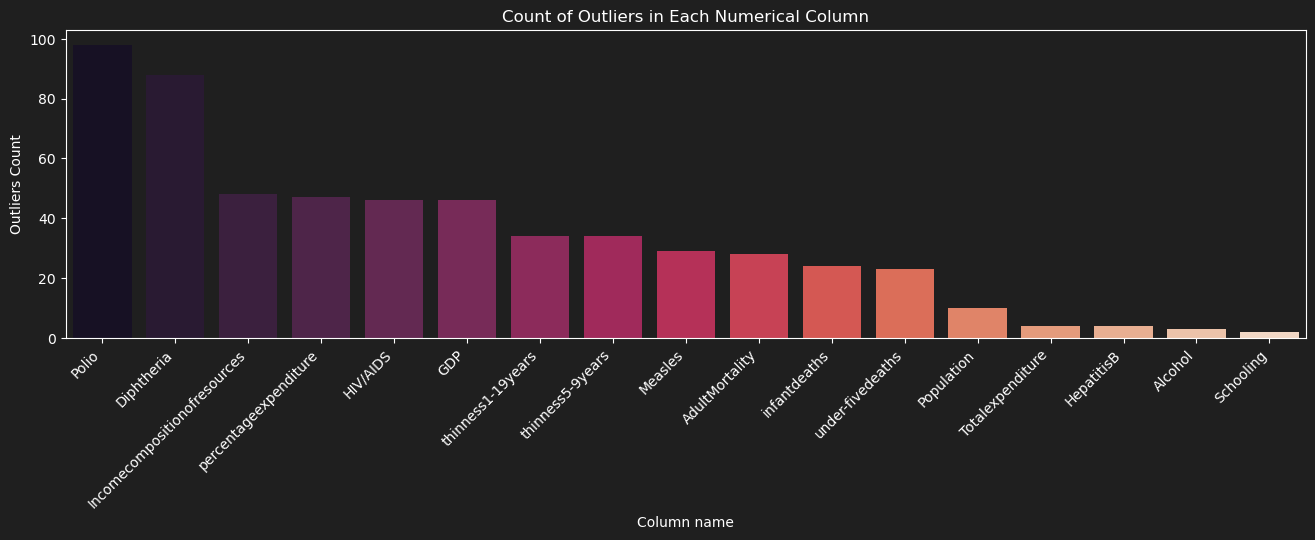

In [478]:
numeric_df = df.select_dtypes(include=['number'])

def find_outliers(df, column):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound, upper_bound = mean - 3 * std, mean + 3 * std
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].copy()
    outliers['column_name'] = column  # Include column name for identification
    return outliers

def plot_outliers(df):
    all_outliers = pd.concat([find_outliers(df, col) for col in numeric_df.columns])
    
    outliers_count = all_outliers['column_name'].value_counts().reset_index()
    outliers_count.columns = ['column_name', 'outliers_count']
    
    with plt.style.context('dark_background'):
        plt.rcParams.update({
            'figure.facecolor': '#1f1f1f',
            'axes.facecolor': '#1f1f1f',
            'axes.edgecolor': 'white',
        })

        plt.figure(figsize=(16, 4))
        bar_plot = sns.barplot(x='column_name', y='outliers_count', data=outliers_count, palette='rocket')
        plt.title('Count of Outliers in Each Numerical Column')
        plt.xlabel('Column name')
        plt.ylabel('Outliers Count')
        plt.xticks(rotation=45, ha='right')

        plt.show()

plot_outliers(df)


In [479]:
def remove_outliers(df, whitelist):
    numeric_df_columns = df.select_dtypes(include=['number']).columns
    outliers_counts = {}

    for col in numeric_df_columns:
        if col in whitelist:
            outliers = find_outliers(df, col)
            outliers_counts[col] = len(outliers)
            
            mean = df[col].mean()
            std = df[col].std()
            lower_bound, upper_bound = mean - 3 * std, mean + 3 * std
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df, outliers_counts

df_cleaned, outliers_counts = remove_outliers(df, ['Schooling', 'Incomecompositionofresources']) # Columns of interest

print(f'Rows before removing outliers: {df.shape[0]}')
print(f'Rows after removing outliers: {df_cleaned.shape[0]}')


Rows before removing outliers: 1649
Rows after removing outliers: 1599


So we got to the point... does schooling really make our life longer?
### 5. test the hypothesis

$$H_0 = \text{Greater education extends life expectancy}$$
$$H_1 = \text{Greater education does not extend life expectancy}$$

#### first test - correlation

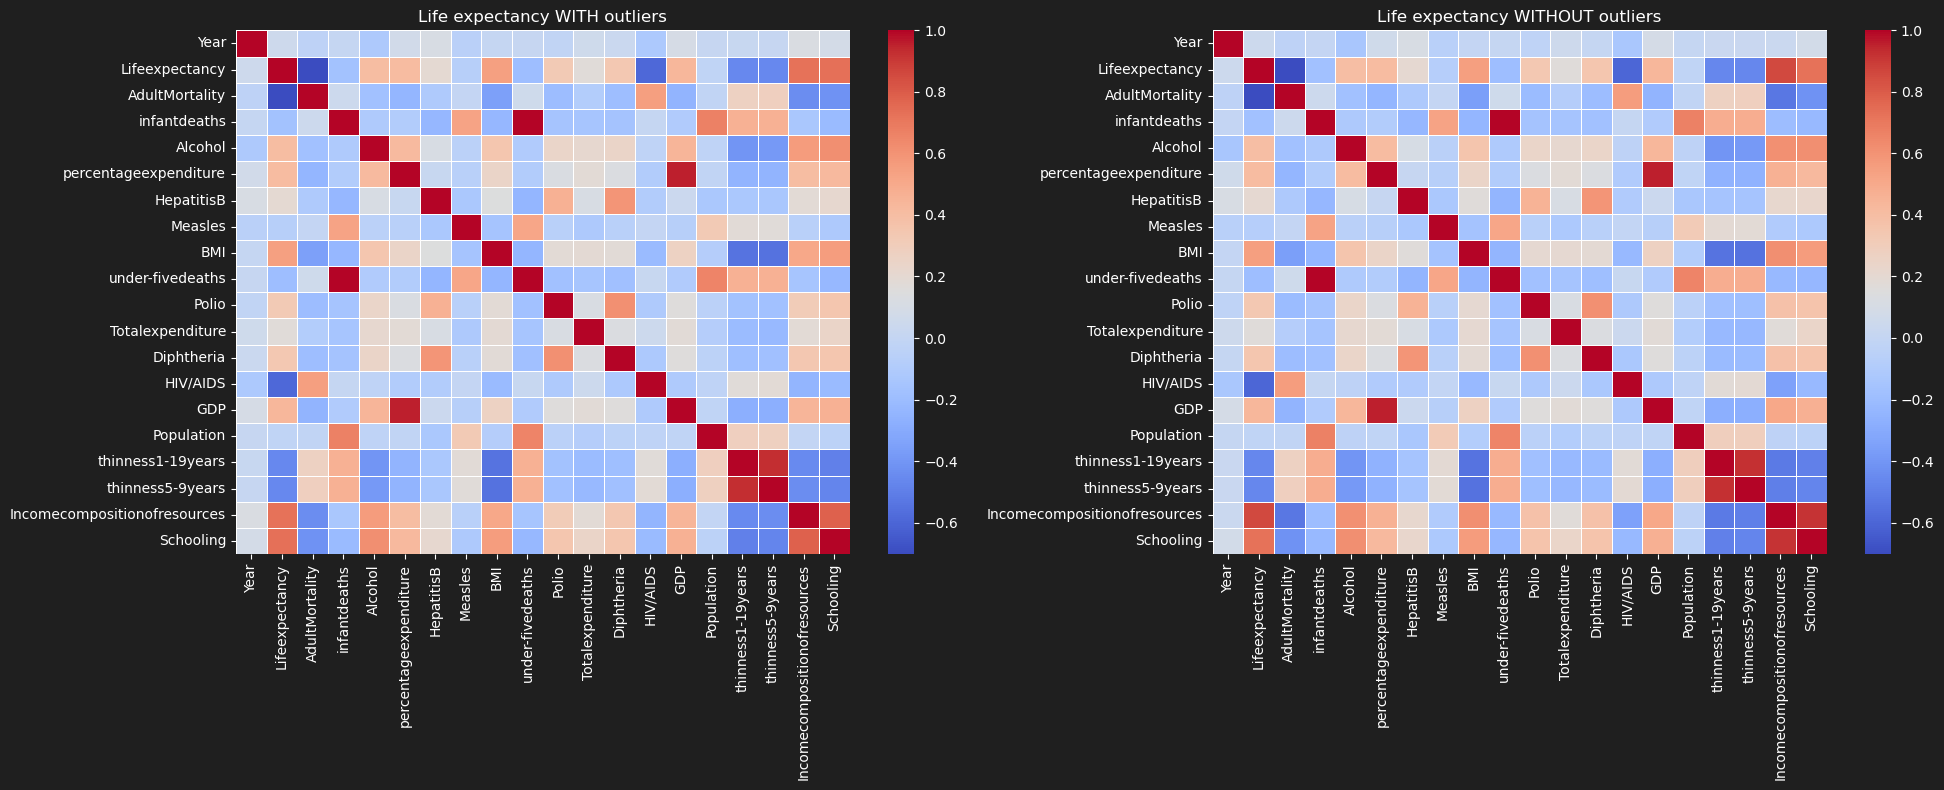

In [480]:
numeric_df_cleaned = df_cleaned.select_dtypes(include=['number'])

corr_matrix_with_outliers = numeric_df.corr()
corr_matrix_without_outliers = numeric_df_cleaned.corr()
with plt.style.context('dark_background'):
    plt.rcParams.update({
        'figure.facecolor': '#1f1f1f',
        'axes.facecolor': '#1f1f1f',
    })

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    sns.heatmap(corr_matrix_with_outliers, cmap="coolwarm", linewidths=0.5, fmt=".2f", ax=axes[0])
    axes[0].set_title('Life expectancy WITH outliers')

    sns.heatmap(corr_matrix_without_outliers, cmap="coolwarm", linewidths=0.5, fmt=".2f", ax=axes[1])
    axes[1].set_title('Life expectancy WITHOUT outliers')

    plt.tight_layout()
    plt.show()

we can see that there __is__ a correlation between Life expectancy and Schooling, but this does not answer our hypothesis, but it does give us a glimpse of knowledge about the relation between our candidates.
<br/>
<br/>
in order to answer our hypothesis we need to understand the distribution of our data to know which tests to take (parametric vs non parametric).

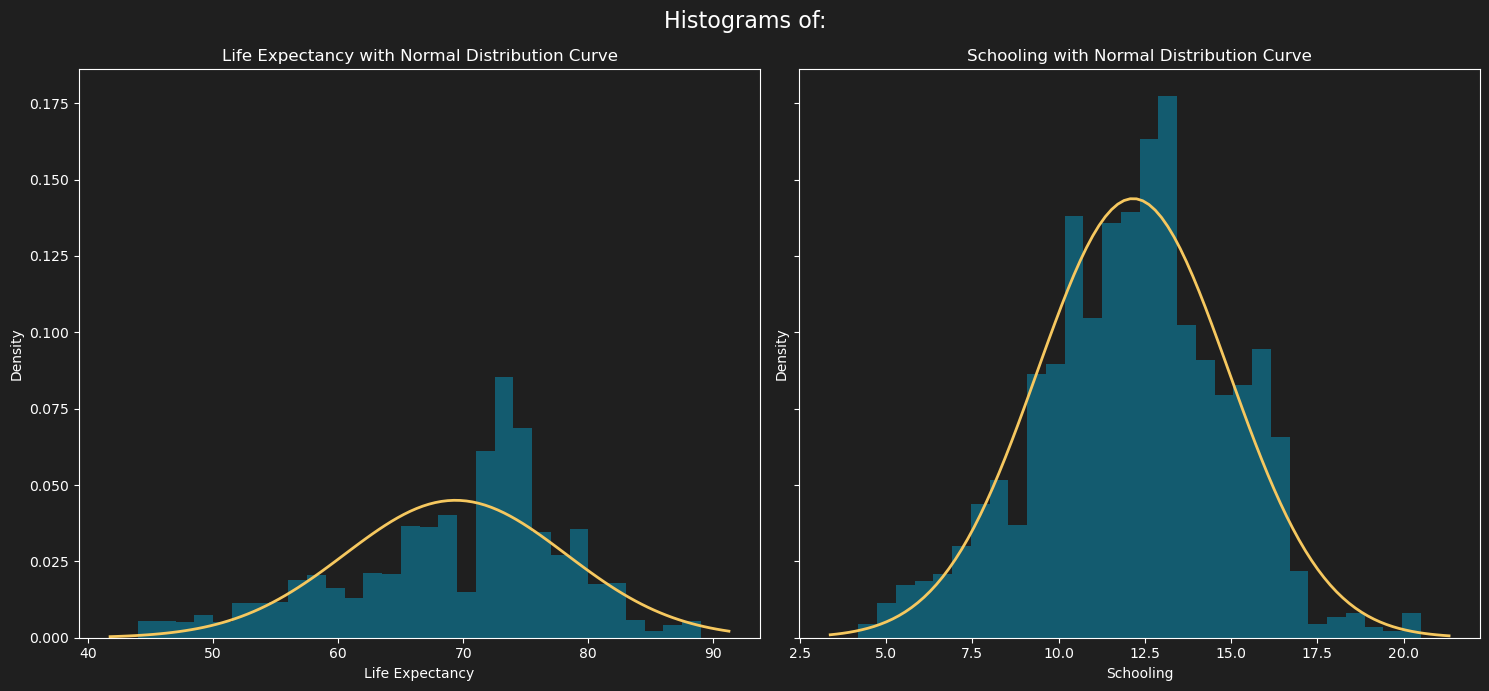

In [481]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
with plt.style.context('dark_background'):
    fig.patch.set_facecolor('#1f1f1f')
    for ax in axes:
        ax.set_facecolor('#1f1f1f')
        ax.tick_params(colors='white', which='both')
        ax.spines['top'].set_color('white')
        ax.spines['bottom'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
    
    # Plot Life Expectancy distribution
    axes[0].hist(df_cleaned['Lifeexpectancy'], bins=30, density=True, alpha=0.6, color='#0b84a5')

    xmin, xmax = axes[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, df_cleaned['Lifeexpectancy'].mean(), df_cleaned['Lifeexpectancy'].std())
    axes[0].plot(x, p, linewidth=2, color='#f6c85f')

    axes[0].set_title('Life Expectancy with Normal Distribution Curve', color='white')
    axes[0].set_xlabel('Life Expectancy', color='white')
    axes[0].set_ylabel('Density', color='white')

    # Plot Schooling distribution
    axes[1].hist(df_cleaned['Schooling'], bins=30, density=True, alpha=0.6, color='#0b84a5')

    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, df_cleaned['Schooling'].mean(), df_cleaned['Schooling'].std())
    axes[1].plot(x, p, linewidth=2, color='#f6c85f')

    axes[1].set_title('Schooling with Normal Distribution Curve', color='white')
    axes[1].set_xlabel('Schooling', color='white')
    axes[1].set_ylabel('Density', color='white')

plt.suptitle('Histograms of:', fontsize=16, color='white')
plt.tight_layout()
plt.show()

In these histograms, we can definitely see that Life expectancy is not normal because it is not centred against the middle,<br/>
but Schooling really does fit the normal distribution.<br/><br/>
so let's test it!

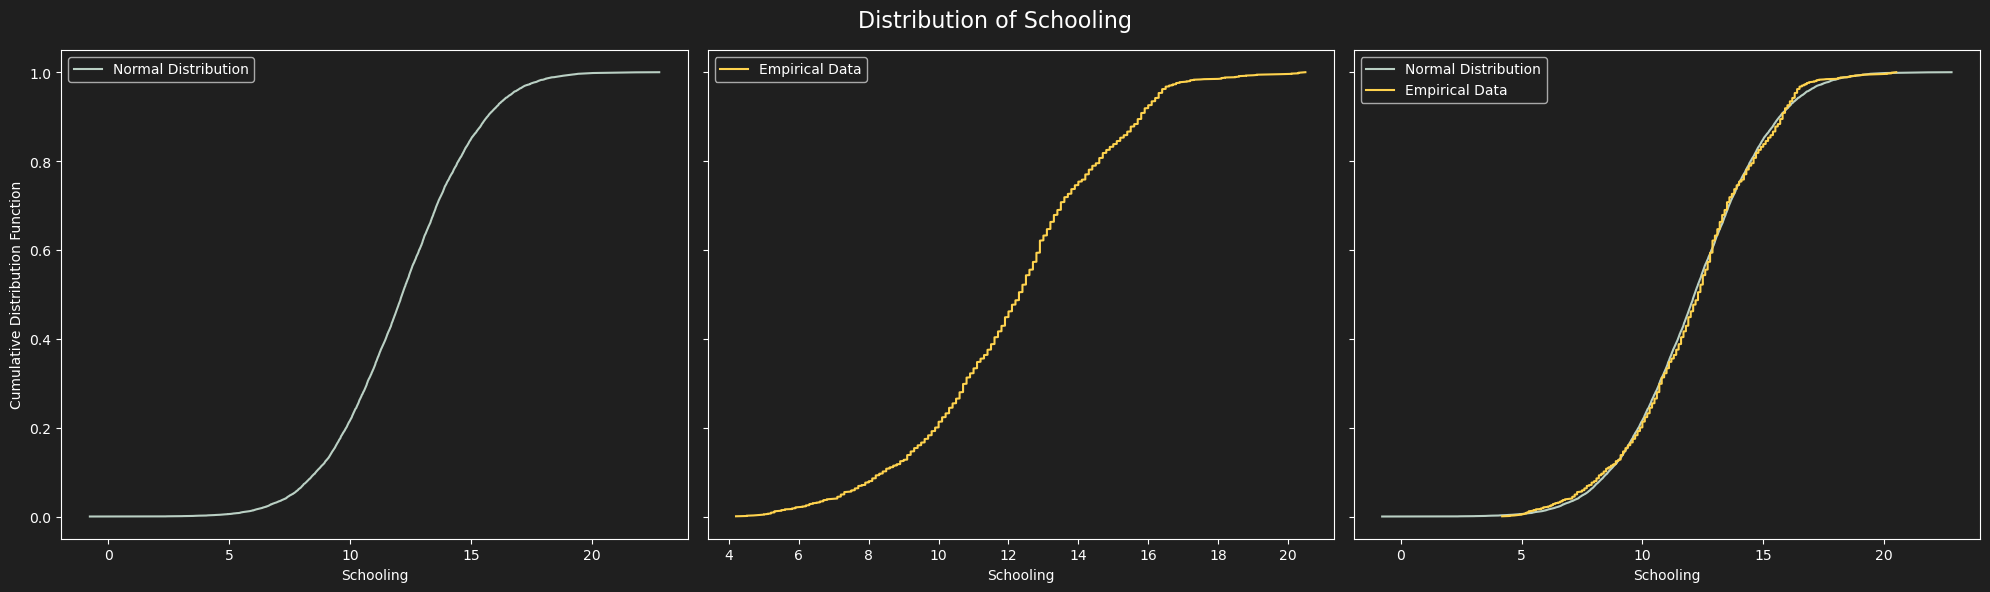

NormaltestResult(statistic=6.5574404931751165, pvalue=0.0376764425235705)
KstestResult(statistic=0.033569481647639565, pvalue=0.05320953094405079, statistic_location=11.9, statistic_sign=-1)


In [482]:
def ecdf(data):
    length = len(data)
    x = np.sort(data)
    y = np.arange(1, length+1) / length
    return x, y

# Generate samples for the normal distribution
samples = np.random.normal(np.mean(df_cleaned["Schooling"]), np.std(df_cleaned["Schooling"]), size=10000)
x_theor, y_theor = ecdf(samples)

x_emp, y_emp = ecdf(df_cleaned["Schooling"])

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
with plt.style.context('dark_background'):
    fig.patch.set_facecolor('#1f1f1f')
    for ax in axes:
        ax.set_facecolor('#1f1f1f')
        ax.tick_params(colors='white', which='both')
        ax.spines['top'].set_color('white')
        ax.spines['bottom'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
    
    # Plot theoretical distribution
    axes[0].plot(x_theor, y_theor, label='Normal Distribution', color='#bad0c4')
    axes[0].set_xlabel("Schooling", color='white')
    axes[0].set_ylabel("Cumulative Distribution Function", color='white')
    axes[0].legend(facecolor='#1f1f1f')

    # Plot empirical data
    axes[1].plot(x_emp, y_emp, label='Empirical Data', color='#ffd34e')
    axes[1].set_xlabel("Schooling", color='white')
    axes[1].legend(facecolor='#1f1f1f')

    axes[2].plot(x_theor, y_theor, label='Normal Distribution', color='#bad0c4')
    axes[2].plot(x_emp, y_emp, label='Empirical Data', color='#ffd34e')
    axes[2].set_xlabel("Schooling", color='white')
    axes[2].legend(facecolor='#1f1f1f')

    fig.suptitle('Distribution of Schooling' , fontsize=16)

plt.tight_layout()
plt.show()

print(stats.normaltest(df_cleaned["Schooling"]))
print(stats.kstest(df_cleaned["Schooling"], 'norm', args=(df_cleaned["Schooling"].mean(), df_cleaned["Schooling"].std()))
)

in the stats.Normaltest we are peforming a 2-sided chi squared probability with the null hypothesis that this sample data is normally distributed.<br/>
if the p-value result is less than our significance level, we will reject the null hypothesis, otherwise, we will accept it.
<br/><br/>
our p-value result is 0.05320953094405079 which is > 0.05 thus, we will accept our null hypothesis:<br/>
- __Schooling is normally distributed__

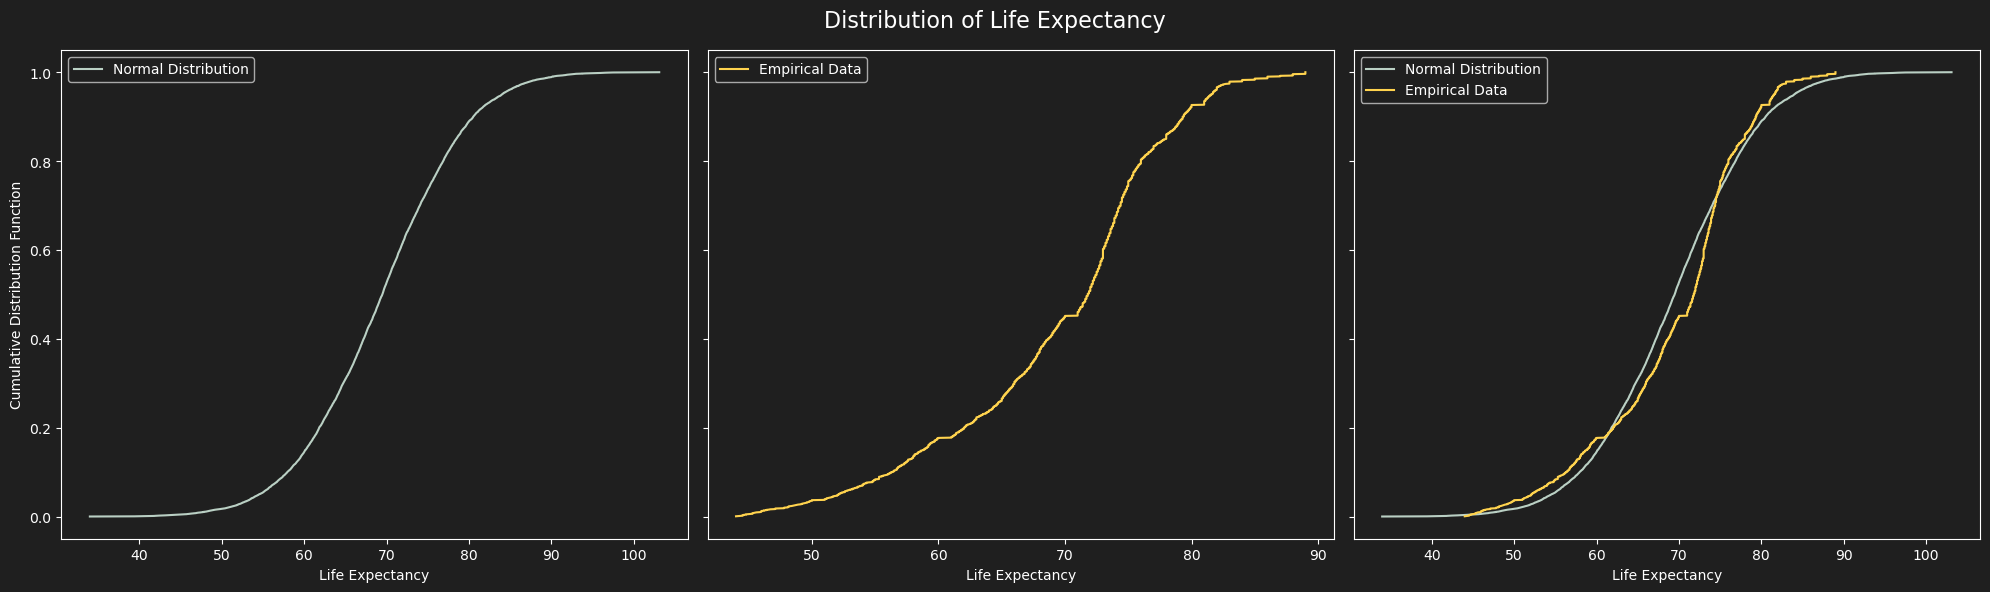

NormaltestResult(statistic=97.07071502102255, pvalue=8.343764849862415e-22)
KstestResult(statistic=0.12128224147747607, pvalue=5.9133569389430564e-21, statistic_location=71.0, statistic_sign=-1)


In [483]:
# Generate samples for the normal distribution
samples = np.random.normal(np.mean(df_cleaned["Lifeexpectancy"]), np.std(df_cleaned["Lifeexpectancy"]), size=10000)
x_theor, y_theor = ecdf(samples)

x_emp, y_emp = ecdf(df_cleaned["Lifeexpectancy"])

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
with plt.style.context('dark_background'):
    fig.patch.set_facecolor('#1f1f1f')
    for ax in axes:
        ax.set_facecolor('#1f1f1f')
        ax.tick_params(colors='white', which='both')
        ax.spines['top'].set_color('white')
        ax.spines['bottom'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
    
    # Plot theoretical distribution
    axes[0].plot(x_theor, y_theor, label='Normal Distribution', color='#bad0c4')
    axes[0].set_xlabel("Life Expectancy", color='white')
    axes[0].set_ylabel("Cumulative Distribution Function", color='white')
    axes[0].legend(facecolor='#1f1f1f')

    # Plot empirical data
    axes[1].plot(x_emp, y_emp, label='Empirical Data', color='#ffd34e')
    axes[1].set_xlabel("Life Expectancy", color='white')
    axes[1].legend(facecolor='#1f1f1f')

    axes[2].plot(x_theor, y_theor, label='Normal Distribution', color='#bad0c4')
    axes[2].plot(x_emp, y_emp, label='Empirical Data', color='#ffd34e')
    axes[2].set_xlabel("Life Expectancy", color='white')
    axes[2].legend(facecolor='#1f1f1f')
    
    fig.suptitle('Distribution of Life Expectancy' , fontsize=16)

plt.tight_layout()
plt.show()

print(stats.normaltest(df_cleaned["Lifeexpectancy"]))
print(stats.kstest(df_cleaned["Lifeexpectancy"], 'norm', args=(df_cleaned["Lifeexpectancy"].mean(), df_cleaned["Lifeexpectancy"].std())))

our p-value result is 8.343764849862415e-22 which is << 0.05 thus, we will reject our null hypothesis:<br/>
- __Life expectancy is not normally distributed__

because we are trying to find a correlation between normal-distribution and non-normal-distribution datasets, we can't use parametric test.
<br/>
so in order to test the hypothesis, we will use few non-parametric tests:

#### Pearson's correlation 

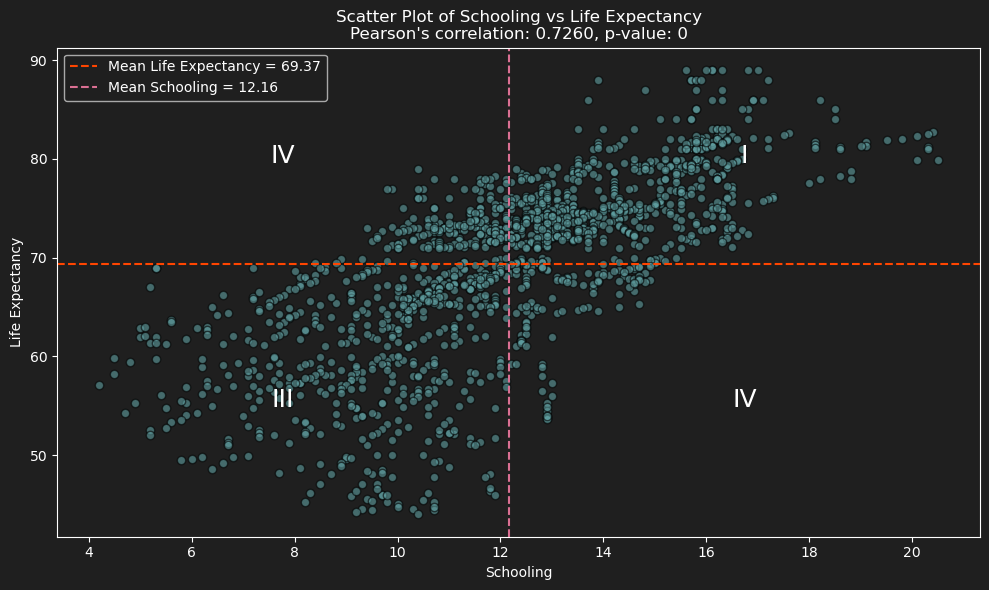

In [484]:
corr, p_value = stats.pearsonr(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'])

with plt.style.context('dark_background'):
    plt.rcParams.update({
        'figure.facecolor': '#1f1f1f',
        'axes.facecolor': '#1f1f1f',
    })

    plt.figure(figsize=(10, 6))
    plt.scatter(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'], alpha=0.6, color='cadetblue', edgecolor='k')

    # Add mean lines
    mean_schooling = df_cleaned['Schooling'].mean()
    mean_lifeexpectancy = df_cleaned['Lifeexpectancy'].mean()

    plt.axhline(mean_lifeexpectancy, color='orangered', linestyle='--', label=f'Mean Life Expectancy = {mean_lifeexpectancy:.2f}')
    plt.axvline(mean_schooling, color='palevioletred', linestyle='--', label=f'Mean Schooling = {mean_schooling:.2f}')

    plt.xlabel('Schooling')
    plt.ylabel('Life Expectancy')
    plt.title(f'Scatter Plot of Schooling vs Life Expectancy\nPearson\'s correlation: {corr:.4f}, p-value: {p_value:.0f}')
    plt.legend()

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    # Midpoints
    x_mid_left = (xmin + mean_schooling) / 2
    x_mid_right = (xmax + mean_schooling) / 2
    y_mid_bottom = (ymin + mean_lifeexpectancy) / 2
    y_mid_top = (ymax + mean_lifeexpectancy) / 2

    plt.text(x_mid_left, y_mid_top, 'IV', fontsize=18, ha='center', va='center', color='white')
    plt.text(x_mid_right, y_mid_top, 'I', fontsize=18, ha='center', va='center', color='white')
    plt.text(x_mid_left, y_mid_bottom, 'III', fontsize=18, ha='center', va='center', color='white')
    plt.text(x_mid_right, y_mid_bottom, 'IV', fontsize=18, ha='center', va='center', color='white')

plt.tight_layout()
plt.show()

Pearson's correlation coefficient is a value between -1, to 1 that indicates the correlation/dependency between two variables, where:
- 1 means a perfect positive relation
- 0 means no relation
- -1 means a perfect negative relation

<br/>
we can see that most of our data is in quarters I & III, which means that pearson's correlation coefficient is going to be positive (of course we already calculated it...)
<br/>
our coefficient is 0.7276 which indicates high positive correlation, meaning:

$$ \text{higher schooling} \longrightarrow \text{higher life expectancy} $$

#### Spearman's correlation 

In [485]:
corr, p_value = stats.spearmanr(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'])
print(f"Spearman's correlation: {corr}, p-value: {p_value}")

Spearman's correlation: 0.7713271306591092, p-value: 1.02862914e-315


#### Linear regression
According to Pearson's coefficient there is a correlation between Schooling and Life expectancy, so in order to find a prediction formula, we will use linear regression.

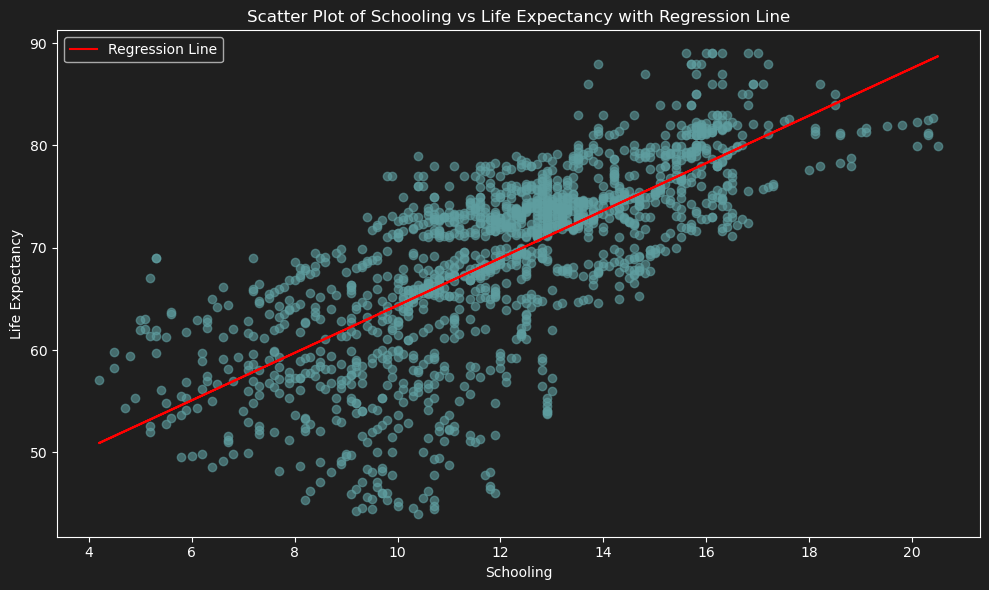

In [487]:
slope, intercept = np.polyfit(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'], 1)

with plt.style.context('dark_background'):
    plt.rcParams.update({
        'figure.facecolor': '#1f1f1f',
        'axes.facecolor': '#1f1f1f',
    })

    plt.figure(figsize=(10, 6))
    plt.scatter(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'], alpha=0.6, color='cadetblue')
    plt.plot(df_cleaned['Schooling'], slope * df_cleaned['Schooling'] + intercept, color='r', label='Regression Line') #min squared

    plt.xlabel('Schooling')
    plt.ylabel('Life Expectancy')
    plt.title('Scatter Plot of Schooling vs Life Expectancy with Regression Line')
    plt.legend()

plt.tight_layout()
plt.show()

The data scatter does seem to follow a linear regression, so let's calculate the linear regression equation

In [488]:
import warnings
from IPython.display import Markdown
warnings.filterwarnings('ignore', category=UserWarning, message='X does not have valid feature names')


model = LinearRegression()

model.fit(df_cleaned[['Schooling']], df_cleaned['Lifeexpectancy'])

modelIntercept = model.intercept_
modelCoef = model.coef_[0]

markdown_text = f"""
$$ \\text{{Prediction equation:}}\\newline\\text{{Life expectancy}} = {modelIntercept:.2f} + {modelCoef:.2f} \\times \\text{{Schooling}} $$
"""
Markdown(markdown_text)



$$ \text{Prediction equation:}\newline\text{Life expectancy} = 41.16 + 2.32 \times \text{Schooling} $$


In [489]:
def predict_life_expectancy(schooling):
    return model.predict([[schooling]]) # type: ignore

print(f'Predicted life expectancy for schooling of 15 years (highschool + first degree): {predict_life_expectancy(15)[0]:.2f}')
print(f'Predicted life expectancy for schooling of 17 years (highschool + first degree + second degree): {predict_life_expectancy(18)[0]:.2f}')
print('\nguess it is a good thing that we are here...')

Predicted life expectancy for schooling of 15 years (highschool + first degree): 75.96
Predicted life expectancy for schooling of 17 years (highschool + first degree + second degree): 82.92

guess it is a good thing that we are here...


A relation between schooling and life expectancy is proven, but why is it?
<br/>
does higher schooling predicts high income which affects life expectancy for the good?
<br/><br/>
We have another interesting column in our dataset, __Income composition of resources__:
<br/>
Human Development Index in terms of income composition of resources (index ranging from 0 to 1) - higher income
<br/>
<br/>
let's try and find a connection between all three...
$$ \text{higher education} \longrightarrow \text{higher income} \longrightarrow \text{higher life expectancy} ?$$
but this actually makes sense!
<br/>
<br/>
- Education equips individuals with knowledge about healthy lifestyles, disease prevention, and the importance of regular medical care, improving overall health and life expectancy.
<br/>
<br/>
- Higher income individuals can afford medications and advanced medical procedures, which contribute to better health outcomes and longer life expectancy.
<br/>
<br/>
- Higher income can minimize financial stress and provide resources for leisure activities, exercise, and relaxation.
Lower stress levels and healthier lifestyle choices, such as balanced diets and physical activity therefore extending life expectancy.
<br/>

theory aside, let's test it.

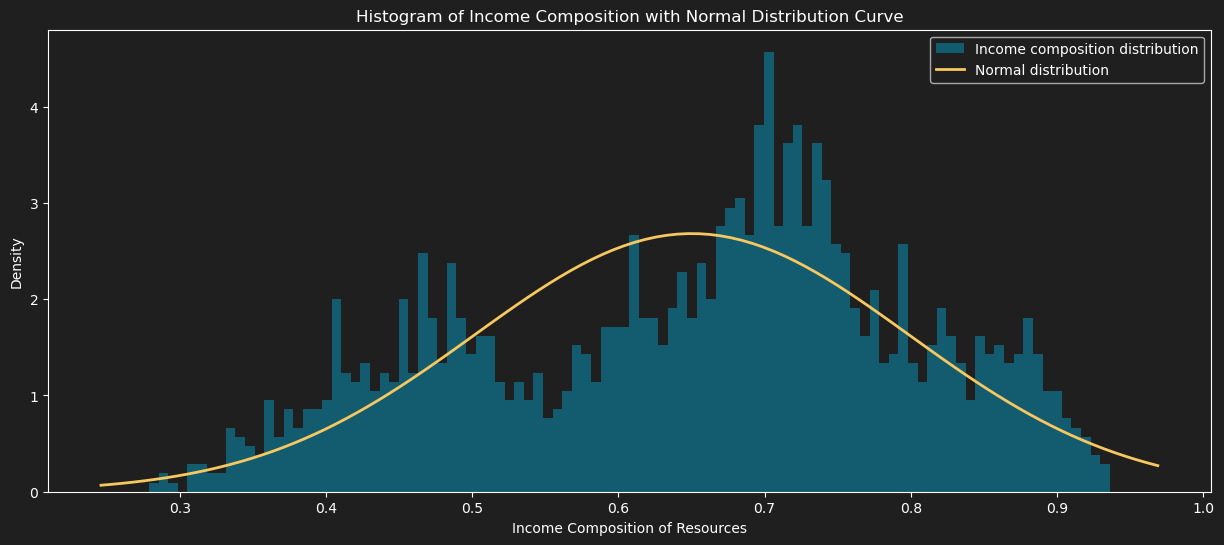

NormaltestResult(statistic=138.68562757431775, pvalue=7.6700573739420205e-31)
KstestResult(statistic=0.07754416486876553, pvalue=8.261769255450045e-09, statistic_location=0.673, statistic_sign=-1)


In [490]:
with plt.style.context('dark_background'):
    plt.rcParams.update({
        'figure.facecolor': '#1f1f1f',
        'axes.facecolor': '#1f1f1f',
    })

    plt.figure(figsize=(15, 6))
    
    # Plot Life Expectancy distribution
    plt.hist(df_cleaned['Incomecompositionofresources'], bins=100, density=True, alpha=0.6, color='#0b84a5', label='Income composition distribution')

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, df_cleaned['Incomecompositionofresources'].mean(), df_cleaned['Incomecompositionofresources'].std())
    plt.plot(x, p, linewidth=2, color='#f6c85f', label='Normal distribution')
    plt.xlabel('Income Composition of Resources', color='white')
    plt.ylabel('Density', color='white')
    plt.legend()

plt.title('Histogram of Income Composition with Normal Distribution Curve', color='white')
plt.show()

print(stats.normaltest(df_cleaned["Incomecompositionofresources"]))
print(stats.kstest(df_cleaned["Incomecompositionofresources"], 'norm', args=(df_cleaned["Incomecompositionofresources"].mean(), df_cleaned["Incomecompositionofresources"].std())))

our p-value result is 8.261769255450045e-09 which is << 0.05 thus, we will reject our null hypothesis:<br/>
- __Income Composition of Resources is not normally distributed__

so again, we will use a-parametric tests.

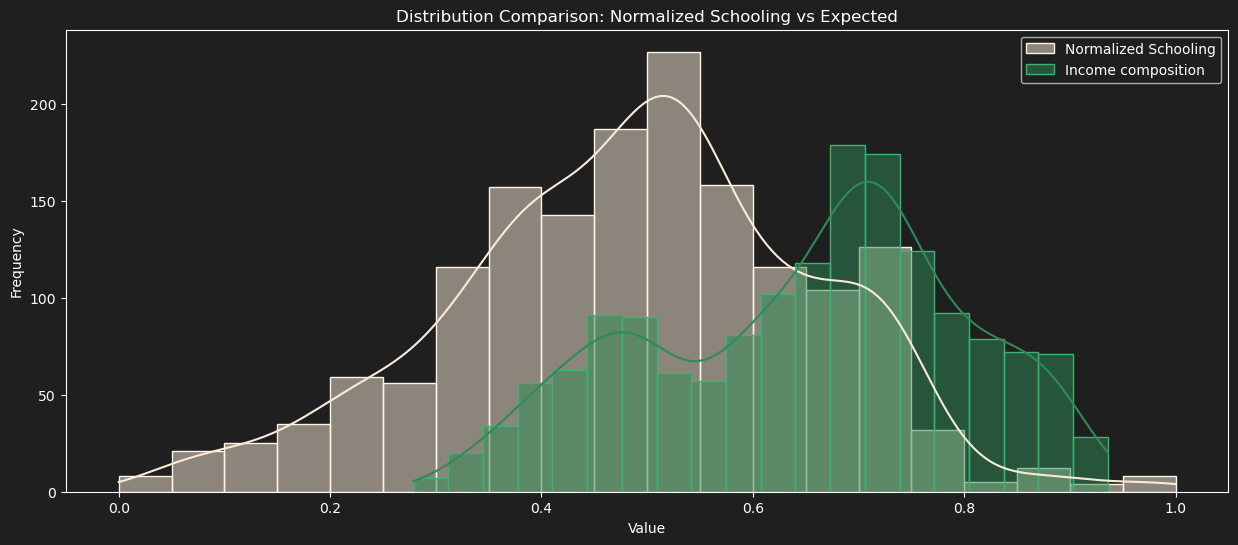

In [491]:
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

observed = df_cleaned['Schooling'].to_numpy()
expected = df_cleaned['Incomecompositionofresources'].to_numpy()

#normalize schooling so both column values will differ from 0 to 1
scaler = MinMaxScaler()
normalized_schooling = scaler.fit_transform(observed.reshape(-1, 1)).flatten()

with plt.style.context('dark_background'):
    plt.rcParams.update({
        'figure.facecolor': '#1f1f1f',
        'axes.facecolor': '#1f1f1f',
    })

    plt.figure(figsize=(15, 6))
    sns.histplot(normalized_schooling, kde=True, bins=20, color='antiquewhite', edgecolor='oldlace', label='Normalized Schooling')
    sns.histplot(expected, kde=True, bins=20, color='seagreen', edgecolor='mediumseagreen', label='Income composition')
    plt.title('Distribution Comparison: Normalized Schooling vs Expected')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
plt.show()


the graphs are a lot alike, they just need some adjustment so its easier to see, and as we know, movement does not affect any correlation

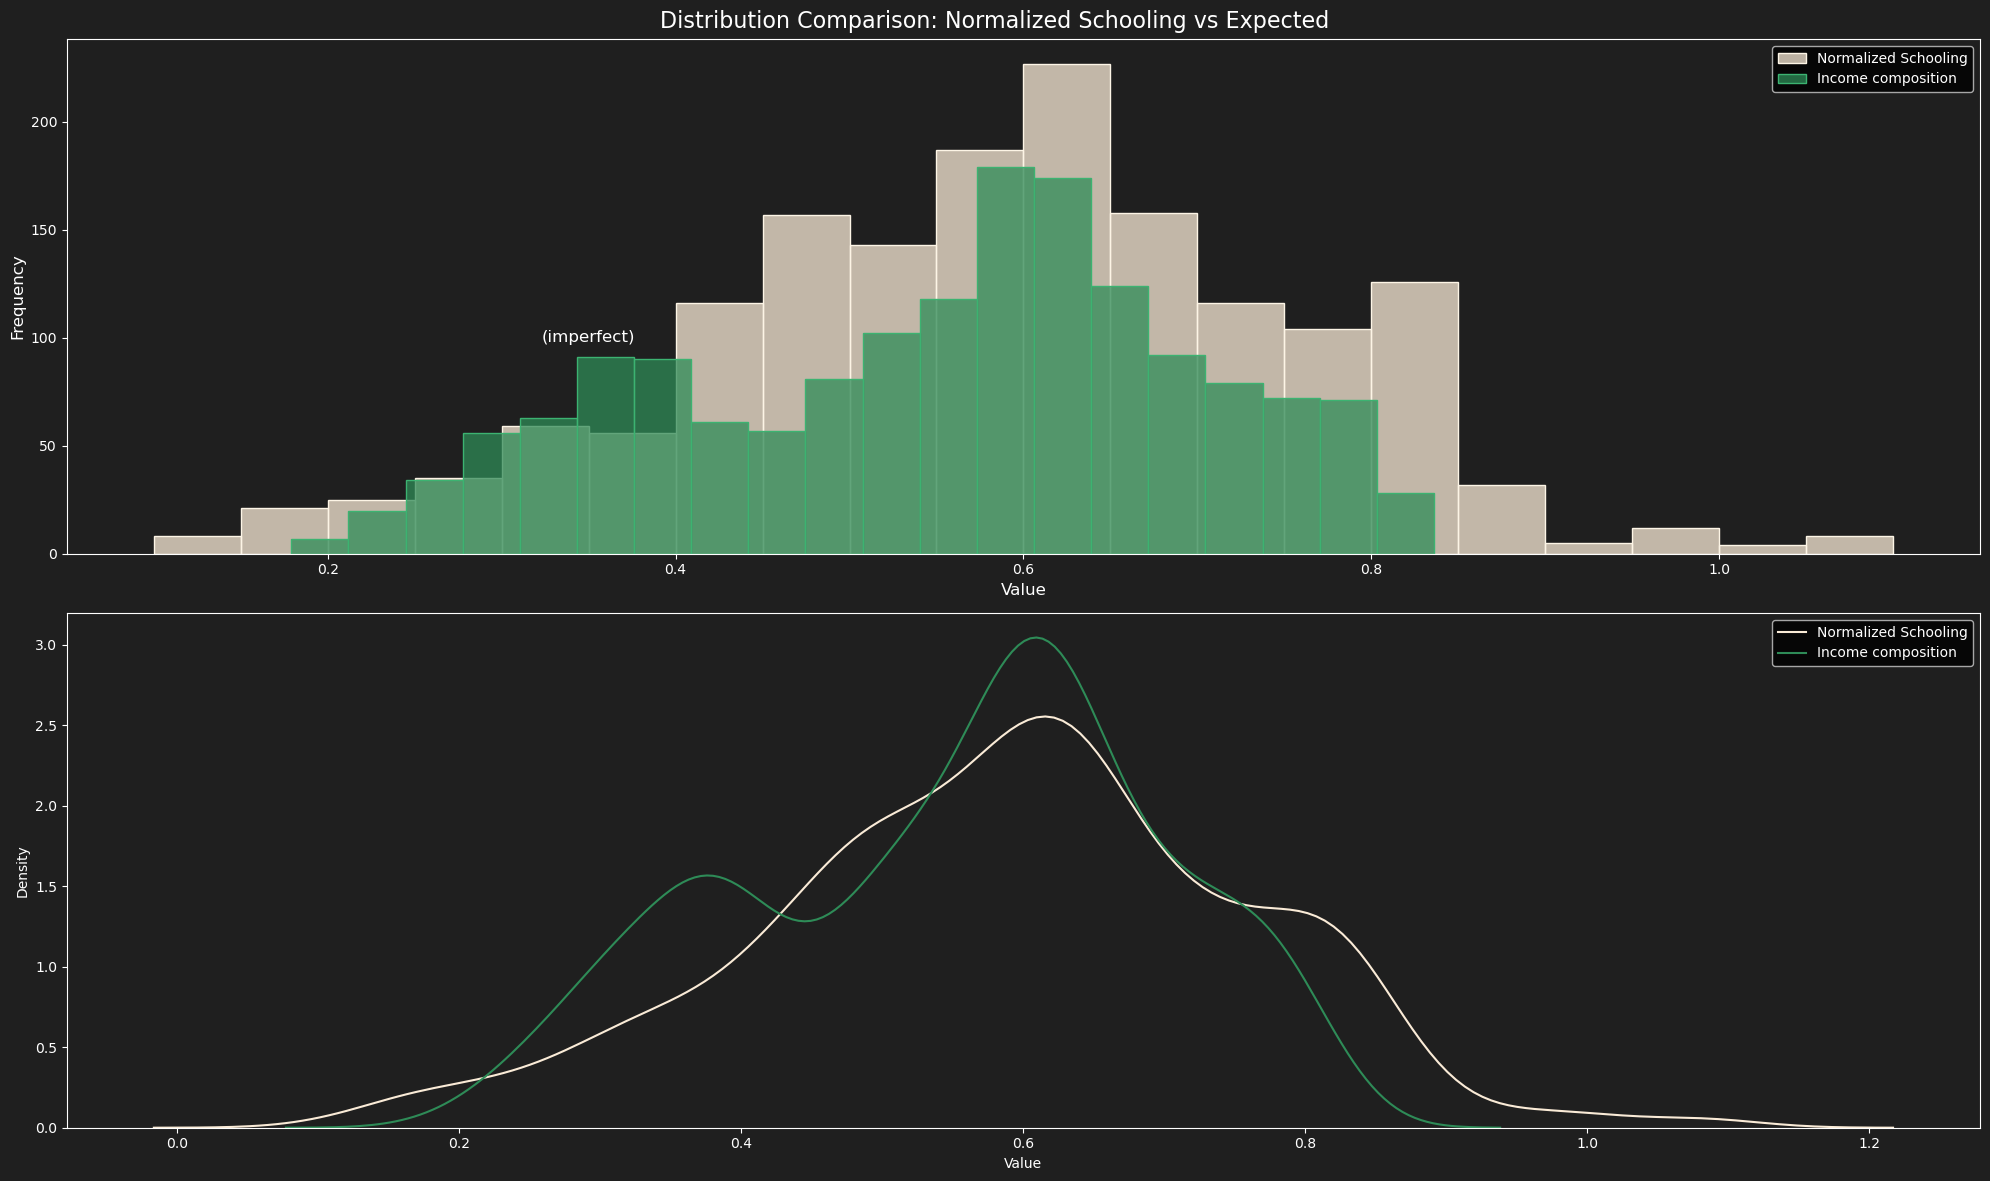

In [492]:
warnings.filterwarnings('ignore', category=FutureWarning)

observed = df_cleaned['Schooling'].to_numpy()
expected = df_cleaned['Incomecompositionofresources'].to_numpy() - 0.1

scaler = MinMaxScaler()
normalized_schooling = scaler.fit_transform(observed.reshape(-1, 1)).flatten() + 0.1

fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharex=False)
with plt.style.context('dark_background'):
    fig.patch.set_facecolor('#1f1f1f')
    for ax in axes:
        ax.set_facecolor('#1f1f1f')
        ax.tick_params(colors='white', which='both')
        ax.spines['top'].set_color('white')
        ax.spines['bottom'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
    
    sns.histplot(normalized_schooling, bins=20, color='antiquewhite', edgecolor='oldlace', label='Normalized Schooling', ax=axes[0])
    sns.histplot(expected, bins=20, color='seagreen', edgecolor='mediumseagreen', label='Income composition', ax=axes[0])
    axes[0].text(0.35, 100, '(imperfect)', color='white', fontsize=12, ha='center', va='center')
    axes[0].set_xlabel('Value', fontsize=12, color='white')
    axes[0].set_ylabel('Frequency', fontsize=12, color='white')
    axes[0].legend()
    
    sns.kdeplot(normalized_schooling, color='antiquewhite', linestyle='-', ax=axes[1], label='Normalized Schooling')
    sns.kdeplot(expected, color='seagreen', linestyle='-', ax=axes[1], label='Income composition')
    axes[1].set_xlabel('Value', color='white')
    axes[1].set_ylabel('Density', color='white')
    axes[1].legend()

plt.suptitle('Distribution Comparison: Normalized Schooling vs Expected', fontsize=16, color='white')
plt.tight_layout()
plt.show()


We can see that the only statistically significant difference between the __expected frequencies__ (Income composition) and the __observed__
(schooling) is near 0.3 (near the word imperfect) but other than that, they seem pretty dependant on one another, so let's perform chi-squared

#### Chi - squared test

In [493]:
contingency_table = pd.crosstab(df_cleaned['Schooling'], df_cleaned['Incomecompositionofresources'])

# Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")


Chi-squared: 102919.53160696238
P-value: 0.0
Degrees of freedom: 77792


our p-value is 0, meaning that there is no statistically significant difference between schooling and income composition
<br/>
so it proves that schooling and income composition are dependant on each other, so let's apply linear regression to visually see the relation

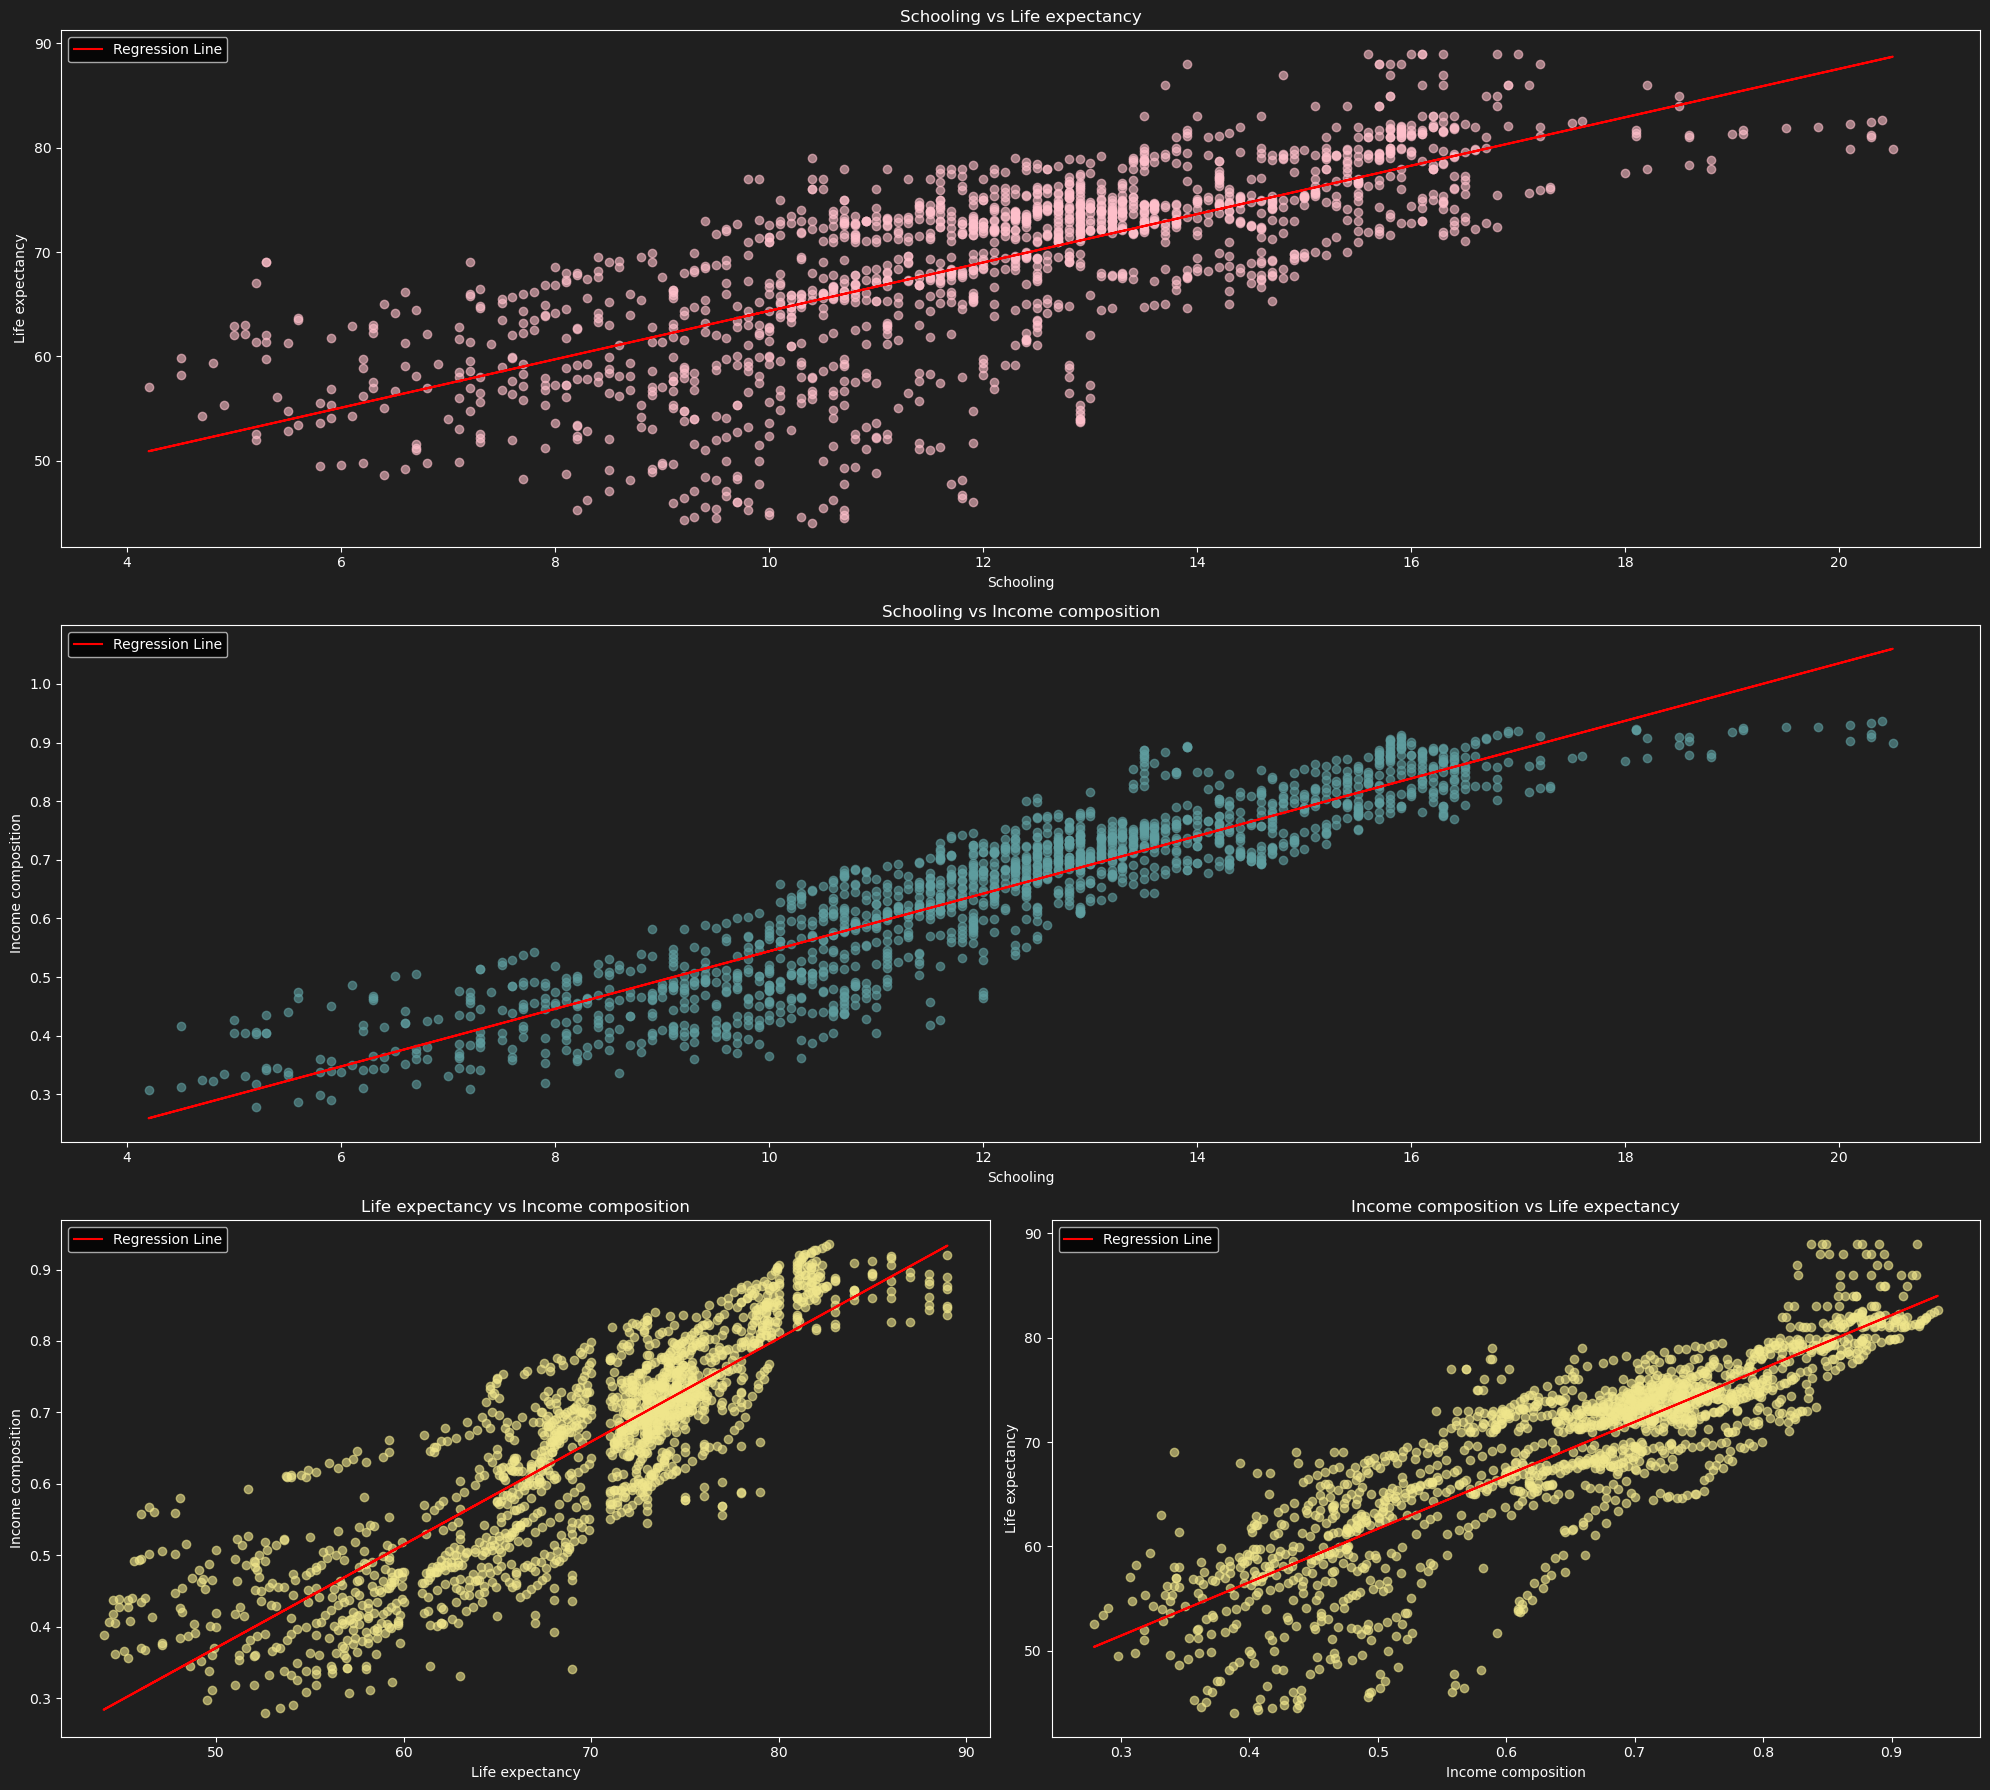

In [494]:
fig = plt.figure(figsize=(20, 18))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1])

with plt.style.context('dark_background'):
    fig.patch.set_facecolor('#1f1f1f')

    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_facecolor('#1f1f1f')
    ax1.tick_params(colors='white', which='both')

    slope, intercept = np.polyfit(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'], 1)
    ax1.scatter(df_cleaned['Schooling'], df_cleaned['Lifeexpectancy'], alpha=0.6, color='pink')
    ax1.plot(df_cleaned['Schooling'], slope * df_cleaned['Schooling'] + intercept, color='r', label='Regression Line')
    ax1.set_xlabel('Schooling', color='white')
    ax1.set_ylabel('Life expectancy', color='white')
    ax1.set_title('Schooling vs Life expectancy', color='white')
    ax1.legend()

    ax2 = fig.add_subplot(gs[1, :])
    ax2.set_facecolor('#1f1f1f')
    ax2.tick_params(colors='white', which='both')

    slope, intercept = np.polyfit(df_cleaned['Schooling'], df_cleaned['Incomecompositionofresources'], 1)
    ax2.scatter(df_cleaned['Schooling'], df_cleaned['Incomecompositionofresources'], alpha=0.6, color='cadetblue')
    ax2.plot(df_cleaned['Schooling'], slope * df_cleaned['Schooling'] + intercept, color='r', label='Regression Line')
    ax2.set_xlabel('Schooling', color='white')
    ax2.set_ylabel('Income composition', color='white')
    ax2.set_title('Schooling vs Income composition', color='white')
    ax2.legend()

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.set_facecolor('#1f1f1f')
    ax3.tick_params(colors='white', which='both')

    slope, intercept = np.polyfit(df_cleaned['Lifeexpectancy'], df_cleaned['Incomecompositionofresources'], 1)
    ax3.scatter(df_cleaned['Lifeexpectancy'], df_cleaned['Incomecompositionofresources'], alpha=0.6, color='khaki')
    ax3.plot(df_cleaned['Lifeexpectancy'], slope * df_cleaned['Lifeexpectancy'] + intercept, color='r', label='Regression Line')
    ax3.set_xlabel('Life expectancy', color='white')
    ax3.set_ylabel('Income composition', color='white')
    ax3.set_title('Life expectancy vs Income composition', color='white')
    ax3.legend()

    ax4 = fig.add_subplot(gs[2, 1])
    ax4.set_facecolor('#1f1f1f')
    ax4.tick_params(colors='white', which='both')

    slope, intercept = np.polyfit(df_cleaned['Incomecompositionofresources'], df_cleaned['Lifeexpectancy'], 1)
    ax4.scatter(df_cleaned['Incomecompositionofresources'], df_cleaned['Lifeexpectancy'], alpha=0.6, color='khaki')
    ax4.plot(df_cleaned['Incomecompositionofresources'], slope * df_cleaned['Incomecompositionofresources'] + intercept, color='r', label='Regression Line')
    ax4.set_xlabel('Income composition', color='white')
    ax4.set_ylabel('Life expectancy', color='white')
    ax4.set_title('Income composition vs Life expectancy', color='white')
    ax4.legend()

plt.tight_layout()
plt.show()


These linear regression prove that there is a relation between all three variables: Schooling, Income composition and Life expectancy!

In [499]:
warnings.filterwarnings('ignore', category=UserWarning, message='X does not have valid feature names')


model = LinearRegression()

model.fit(df_cleaned[['Schooling']], df_cleaned['Incomecompositionofresources'])

modelIntercept1 = model.intercept_
modelCoef1 = model.coef_[0]

model.fit(df_cleaned[['Incomecompositionofresources']], df_cleaned['Lifeexpectancy'])

modelIntercept2 = model.intercept_
modelCoef2 = model.coef_[0]
markdown_text = f"""
$$
\\text{{Prediction equations:}}\\newline
\\text{{Income composition}} = {modelIntercept1:.2f} + {modelCoef1:.2f} \\times \\text{{Schooling}}\\newline
\\text{{Life expectancy}} = {modelIntercept2:.2f} + {modelCoef2:.2f} \\times \\text{{Income composition}}
$$
$$ 
\\Longrightarrow \\text{{Life expectancy}} = {(modelIntercept2 + modelCoef2*modelIntercept1):.2f} + {(modelCoef2*modelCoef1):.2f} \\times \\text{{Schooling}}
$$
$$
\\text{{which is quite similar to our direct equation from before:}}\\newline
\\text{{Life expectancy}} = {modelIntercept:.2f} + {modelCoef:.2f} \\times \\text{{Schooling}}
$$
"""
Markdown(markdown_text)



$$
\text{Prediction equations:}\newline
\text{Income composition} = 0.05 + 0.05 \times \text{Schooling}\newline
\text{Life expectancy} = 36.06 + 51.23 \times \text{Income composition}
$$
$$ 
\Longrightarrow \text{Life expectancy} = 38.77 + 2.52 \times \text{Schooling}
$$
$$
\text{which is quite similar to our direct equation from before:}\newline
\text{Life expectancy} = 41.16 + 2.32 \times \text{Schooling}
$$


##### In conclusion, at a confidence level of 95%, where schooling (education years) is normally distributed,<br/>
##### we found a direct positive relation between schooling and life expectancy,<br/>
##### where schooling has a positive correlation with income composition,<br/>and income composition has a direct positive relation with life expectancy!
<br/><br/>
##### so stay in school, earn more, live longer :)